<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/Lab3_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 3 - LINEAR REGRESSION IN PYTHON

This lab is comprised of two main parts. We will see two ways of running Multiple Linear Regression:
- 1. MLR with only numerical variables
- 2. MLR with numerical + categorical variables

We will use the Linear Regression package from the `statsmodels` library. This library includes a variety of functions that are helpful for data exploration and statiscal models, its documentation can be found here: https://www.statsmodels.org/stable/index.html.

For data visualization, we will first introduce `seaborn` (https://seaborn.pydata.org), which provides a high-level interface for drawing attractive and informative statistical graphics. Later, we will gradually pick up `matplotlib`, which is a more foundamental and versatile library for plotting in `Python`.


For all packages mentioned above, if you have not done so already, you need to install the package. A common approach is to use `conda` or `pip`. In the terminal, type the following commands to install `statsmodels` (change the package name to install other packages):
- 1. `conda install -c conda-forge statsmodels`, or
- 2. `pip install statsmodels`

More specifically, we will use Linear Regression to predict the quality of the wines as measured by their 'Auction Index'




In [ ]:
%pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd

As in the previous Lab, we use pandas to read the data from a `.csv` file, and consolidate it into a `Dataframe` object.

### 2 ways to import csv files to Colab

In [ ]:
# Method 1: from computer
from google.colab import files

uploaded = files.upload()

In [ ]:
import io

df = pd.read_csv(io.BytesIO(uploaded['Rogue-142-Spring2024.csv']))
print(df)

In [ ]:
# Method 2: from Google Drive
import os

In [ ]:
os.getcwd()  # Check current working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to Colab

In [ ]:
new_path = '/content/drive/MyDrive/IEOR142A-Spring24-Lab/'
os.chdir(new_path)  # Change working directory to new_path
print(os.getcwd())

In [ ]:
wine = pd.read_csv('wine_agg.csv')
wine.info()

In [ ]:
wine.head(5)

In [ ]:
# Plot scatter matrix for each pair of variables off diagonal and the histograms (or density plots) on the diagonal
import seaborn as sns

sns.pairplot(wine.iloc[:,1:9],diag_kind='kde') #kernel density estimate: plots data using a continuous probability density curve

In [ ]:
sns.pairplot(wine.iloc[:,1:9],diag_kind='hist') # try diag_kind='hist' for histograms

In [ ]:
# If you apply .corr() directly to your dataframe,
# it will return all pairwise correlations between your columns;
wine.corr()

In [ ]:
import matplotlib.pyplot as plt

correlation_mat = wine.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation_mat, annot = True, linewidth=0.5, ax=ax)
plt.show()

## 1. Multiple Linear Regression (with only numerical variables)

### Dataset train-test splitting

Next, we will split the dataset into a training set and a test set. There are various ways of splitting the dataset, we will first do an example of chronological separation. Eventually we'll cover randomized splitting as well.

We can do chronological splitting sing Boolean predicates, the same way we used them in the last lab:
- A & B
- A | B
- A == B
- A <= B
- A > B



In [ ]:
wine_train = wine[wine['Year'] <= 1985]
wine_test = wine[wine['Year'] > 1985]

len(wine_train), len(wine_test)

In [ ]:
### produce wine_train2 which consists of wine that's older than 40
wine_train2 = wine[wine['Age'] > 40]

### How many rows does this dataset have?
len(wine_train2)

In [ ]:
## produce wine.train3 which is composed of wine less than Year 1985 or older than year 1990.
wine_train3 = wine[(wine['Year'] <= 1985) | (wine['Year'] > 1990)]

# How many rows are there in the rest of the dataset, other than wine.train3?
len(wine)-len(wine_train3)

### Training the model

We will show two ways of passing the data into the model:

- We can select the columns of interest that will constitute our matrices

- Or we can use syntaxis that follows R-style formulas




### 1) Training the model (matrix style)

https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

In [ ]:
# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

# Choose the features to be used
cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'FrancePop', 'USAlcConsump']
X_train = wine_train[cols]
y_train = wine_train['LogAuctionIndex']

# We must add an intercept as the standard model doesn't automatically fit one
X_train = sm.add_constant(X_train)

print(X_train[:5])

In [ ]:
# Fit the data to the model
model1 = sm.OLS(y_train, X_train).fit() #ordinary least square
print(model1.summary())

### Plot the coefficients and the confidence intervals
In `R` and `ggplot2`, one can use function `ggcoef` to create such graph easily. However, there is no simple solution to this task in Python. The code below is a user-defined code credit to Jessica Forrest-Baldini
(https://medium.com/analytics-vidhya/create-your-own-coefficient-plot-function-in-python-aadb9fe27a77). It involves some work with `Matplotlib`. You are encouraged to figure out why the code works.

In [ ]:
import matplotlib.pyplot as plt
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of
    the coefficients with 95% confidence intervals.

    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary
    coef_df = pd.DataFrame(results.summary().tables[1].data)

    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']

    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)

    # Add variables column to dataframe
    coef_df['variables'] = variables

    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(8, 5))

    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22,
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)

    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)

    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]),
               marker='o', s=80,
               y=coef_df['coef'], color='steelblue')

    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)

    return plt.show()


In [ ]:
coefplot(model1)

### 2) Training the model (using R-style formulas)

https://www.statsmodels.org/stable/example_formulas.html#categorical-variables

One of the main advantages of using this type of notation is the fact that categorical variables are handled automatically.

Furthermore, the constant representing the intercept is generated by default in `smf.ols`.

For the remaineder of this lab, we will stick with the formula style notation as presented below:

In [ ]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + FrancePop + USAlcConsump',
                 data=wine_train)
model1 =ols.fit()
print(model1.summary())

### Evaluating the model

If we want to use evaluation metrics that are not contained in the standard package, such as Out-of-sample R^2, we can manipulate our dataframe's columns and take advantage of `numpy's` matrix operation functions

### SST, SSR, SST

For observed data points $y_i$, predicted data points $\hat{y}_i$, mean of observed data points $\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i$,

Sum of Squares Total (SST) / Total Sum of Squares (TSS)

> $\text{SST} = Σ(y_i – \bar{y})^2$

Sum of Squares Regression (SSR) / Explained Sum of Squares (ESS)

> $\text{SSR} = Σ(\hat{y}_i – \bar{y})^2$

Sum of Squares Error (SSE) / Residual Sum of Squares (RSS)

> $\text{SSE} = Σ(\hat{y}_i – y_i)^2$


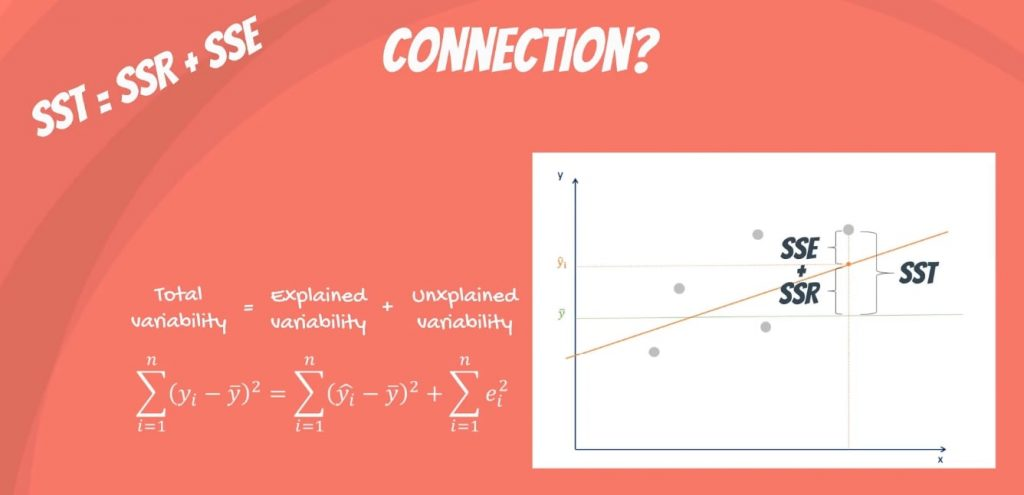

ref:https://365datascience.com/tutorials/statistics-tutorials/sum-squares/

R-squared (coefficient of determination): proportion of the variance in $y_i$'s that can be explained by $\hat{y}_i$'s

> $R^2_{\text{in-sample}} = 1- \frac{\text{SSE}}{\text{SST}} = 1 -\frac{Σ_{i=1}^n(y_i – \hat{y}_i)^2}{Σ_{i=1}^n({y}_i – \bar{y})^2}$ : In-Sample R-squared


> adjusted $R^2_{\text{in-sample}} = 1- \frac{\text{SSE}/(n-p-1)}{\text{SST}/(n=1)} = 1-\frac{n-1}{n-p-1} \cdot \frac{Σ_{i=1}^n(y_i – \hat{y}_i)^2}{Σ_{i=1}^n({y}_i – \bar{y})^2} = 1-\frac{n-1}{n-p-1}(1-R^2)$

$\rightarrow$ Penalize by number of independent variables (prevent overfitting)


> $R^2_{\text{out-of-sample}} = 1-\frac{\sum_{j \in T}(y_j - \hat{y}_j)^2}{\sum_{j \in T} (y_j - \bar{y})^2}$ : Out-of-Sample R-squared



In [ ]:
# compute out-of-sample R-squared using the test set
def OSR2(model, df_train, df_test, dependent_var):
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)
    return 1 - SSE/SST

In [ ]:
OSR2(model1, wine_train, wine_test, 'LogAuctionIndex')

<font color='blue'>
    
### [Sidenote - Programming Exploration]

Generally speaking, there are two types of programming exploration:

1. Finding which function to utilize
2. Understanding how to use a function once you've found it

For 1   -- Try to target the problem you want to address as succinctly as possible in google.

---------- Read the description of the function and what it returns

For 2   -- What to do with new functions that you've never seen before?

---------- Read the arguments carefully, look at examples, try it out and test output

</font>

### Variable Selection - Variance Inflation Factor (VIF)

In [ ]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'FrancePop', 'USAlcConsump']
VIF(wine_train, cols)

### A better model...

In [ ]:
# remove FrancePop because of its high VIF
model2 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + USAlcConsump',
                 data=wine_train).fit()
print(model2.summary())

cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'USAlcConsump']
VIF(wine_train, cols)

In [ ]:
# remove USAlcConsump
model3 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age',
                 data=wine_train).fit()
print(model3.summary())

cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age']
VIF(wine_train, cols)

In [ ]:
# remove HarvestTemp
model4 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_train).fit()
print(model4.summary())

cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'Age']
VIF(wine_train, cols)

In [ ]:
OSR2(model1, wine_train, wine_test, 'LogAuctionIndex')

In [ ]:
OSR2(model2, wine_train, wine_test, 'LogAuctionIndex')

In [ ]:
OSR2(model3, wine_train, wine_test, 'LogAuctionIndex')

In [ ]:
OSR2(model4, wine_train, wine_test, 'LogAuctionIndex')

### Feature Engineering

In [ ]:
# Let us add an interaction term of GrowTemp and Age, and test its predictive power
model5 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp * Age',
                 data=wine_train).fit()
print(model5.summary())

## Exercises

(1) Using the same data set, wine_agg.csv, split the data into a training set and a test set as follows:
*   training set : wine that the year is even number
*   test set : wine that the year is odd number

How many rows are in each set?


(2) Train linear regression models using only one independent variable at a time and compute the out-of-sample R-squared of each model.

(3) Comparing the out-of-sample R-squared values, which model make sense?
What is the 95% confidence interval for the coefficient of the independent variable of that model?

## 2. MLR (with numerical + categorical variables)

For this part, we will use a second dataset, `wine_disagg.csv`, which contains additional information related to the Wineries. The `Winery` variable is a `string object`, but we can do some transformations that will help us fit it into the continuous model

In [ ]:
wine_new = pd.read_csv("wine_disagg.csv")
wine_new_train = wine_new[wine_new['Year'] <= 1985]
wine_new_test = wine_new[wine_new['Year'] > 1985]

wine_new.info()
wine_new.head()

dummy variable
winery A {1, 0}
Winery B {1, 0}
...
Winery E

In [ ]:
# Simple regression using new data, not yet incorporating the Winery variable
modOld = smf.ols(formula='LogAuction ~ WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_new_train).fit()
print(modOld.summary())

In [ ]:
# compute the out-of-sample R squared
OSR2(modOld,wine_new_train, wine_new_test, 'LogAuction')

Next, let us plot the price of the wine versus year, by different wineries

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
g = sns.lineplot(x="Year", y="LogAuction", hue="Winery", data=wine_new)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # This line is to display the lengend out of the graph region.

In [ ]:
# Plot the responses for different events and regions
g = sns.scatterplot(x="Year", y="LogAuction", hue="Winery", data=wine_new).set_title('Log of Wine Price by Winary, Scatter Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Two Wineries
Before constructing a complete model for all the wineries, let's first attempt to regress on only 2 wineries. We pick Cheval Blanc and Cos d'Estournel as an example

In [ ]:
wine_two = wine_new[(wine_new['Winery'] == 'Cheval Blanc') | (wine_new['Winery'] == 'Cos d\'Estournel')]

g = sns.lineplot(x="Year", y="LogAuction", hue="Winery", data=wine_two).set_title('Log of Wine Price, Two Winary')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

wine_two_train = wine_two[wine_two['Year'] <= 1985]
wine_two_test = wine_two[wine_two['Year'] > 1985]
wine_two_train.tail()

### Passing a categorical variable
To use a categorical variables like `Winery`, we can simply pass it to the formula, and `smf.ols` will handle the variable.

In [ ]:
modTwo = smf.ols(formula='LogAuction ~ Winery + WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_two_train).fit()
print(modTwo.summary())

### More Wineries
Now let's expand to the complete set of values that `Winery` can take:

In [ ]:
modNew = smf.ols(formula='LogAuction ~ Winery + WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_new_train).fit()
print(modNew.summary())

### Evaluate our final model

In [ ]:
# compute out-of-sample R squared
OSR2(modNew, wine_new_train, wine_new_test, 'LogAuction')